# Mini-Lab

#### Alan Abadzic, John Girard, Eric Laigaie, Garrett Shankel

In [96]:
import numpy as np
import pandas as pd

df = pd.read_csv("NY_Listings_Validated.csv")

##### Data Load-In and Preprocessing

In [108]:
# First, we need to create our classification column. Any rentals with a Review Scores Rating above 90 receive "A" (or 1),
# else recieve "Not A" (or 0).

def categorise(row):  
    if row['Review Scores Rating'] > 89:
        return 1
    else:
        return 0
    return 'IDK'

df['Grade'] = df.apply(lambda row: categorise(row), axis=1)

df['Grade'].value_counts(normalize=True)

1    0.626667
0    0.373333
Name: Grade, dtype: float64

In [98]:
# Filter to only useful columns
data = df[['Host Response Rate', 'Host Is Superhost', 'Host total listings count', 'City', 'Room type',
          'Accommodates', 'Bathrooms', 'Bedrooms', 'Price', 'Minimum nights', 'Maximum nights', 'Availability 365',
          'Number of reviews', 'Reviews per month', 'Grade']]



# One-hot Encode
city_one_hot = pd.get_dummies(data['City'])
room_one_hot = pd.get_dummies(data['Room type'])

data = data.drop('City',axis = 1)
data = data.drop('Room type',axis = 1)

data = data.join(city_one_hot)
data = data.join(room_one_hot)


# Map boolean to integer
data["Host Is Superhost"] = data["Host Is Superhost"].astype(int)



# Scale Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

grade = data['Grade']
to_scale = data.drop("Grade", axis = 1)
cols = to_scale.columns

scaled = scaler.fit_transform(to_scale)

data = pd.DataFrame(scaled, columns = cols)
data['Grade'] = grade

In [99]:
# Split into 80/20 train/test split.
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

print("Train: " + str(len(train)) + ", Test: " + str(len(test)))

train_y = train['Grade']
train_x = train.drop('Grade', axis=1)
test_y = train['Grade']
test_x = train.drop('Grade', axis=1)

Train: 35220, Test: 8805


## Create Models

#### Logistic Regression Testing

In [106]:
# Logistic Regression Model
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
import time

def cm_stats(cm):
    tn, fp, fn, tp = cm.ravel()
    sens = str(round(((tp) / (tp + fn)) * 100,2)) + "%"
    spec = str(round(((tn) / (tn + fp)) * 100,2)) + "%"
    f1 = str(round(((2 * tp) / ( 2*tp + fp + fn)) * 100,2)) + "%"
    return [sens, spec, f1]

penalties = ['none', 'l1', 'l2', 'elasticnet']
print("TESTING DIFFERENT PENALTIES:")
for penalty in penalties:
    start = time.time()
    if penalty == 'elasticnet':
        clf = LogisticRegression(max_iter=1000, penalty=penalty, solver='saga', l1_ratio =0.5).fit(train_x, train_y)
    else:
        clf = LogisticRegression(max_iter=1000, penalty=penalty, solver='saga').fit(train_x, train_y)
    end = time.time()
    predictions = clf.predict(test_x)
    acc = round((mt.accuracy_score(predictions, test_y)) * 100,2)
    cm_output = cm_stats(mt.confusion_matrix(test_y,predictions))
    print(penalty + ": " + str(acc) + '%, Time: ' + str(end - start) + ' seconds')
    print(penalty + ": " + "Sens: " + cm_output[0] + ", Spec: " + cm_output[1] + ", F1: " + cm_output[2] + '\n')

print('')
Cs = [0.05, .5, 1, 100]
print("TESTING DIFFERENT C VALUES WITH ELASTIC NET PENALTY:")
for c in Cs:
    start = time.time()
    clf = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=c).fit(train_x, train_y)
    end = time.time()
    predictions = clf.predict(test_x)
    acc = round((mt.accuracy_score(predictions, test_y)) * 100,2)
    cm_output = cm_stats(mt.confusion_matrix(test_y,predictions))
    print(str(c) + ": " + str(acc) + '%, Time: ' + str(end - start) + ' seconds')
    print(str(c) + ": " + "Sens: " + cm_output[0] + ", Spec: " + cm_output[1] + ", F1: " + cm_output[2] + '\n')

TESTING DIFFERENT PENALTIES:


C:\Users\ericl\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


none: 71.59%, Time: 15.755988836288452 seconds
none: Sens: 82.3%, Spec: 53.68%, F1: 78.38%

l1: 71.59%, Time: 0.4240388870239258 seconds
l1: Sens: 82.43%, Spec: 53.46%, F1: 78.41%

l2: 71.64%, Time: 0.3727288246154785 seconds
l2: Sens: 83.27%, Spec: 52.2%, F1: 78.61%

elasticnet: 71.68%, Time: 0.3311440944671631 seconds
elasticnet: Sens: 82.87%, Spec: 52.96%, F1: 78.55%

TESTING DIFFERENT C VALUES WITH ELASTIC NET PENALTY:
0.05: 70.59%, Time: 0.33161354064941406 seconds
0.05: Sens: 89.66%, Spec: 38.69%, F1: 79.23%

0.5: 71.68%, Time: 0.31415581703186035 seconds
0.5: Sens: 83.4%, Spec: 52.08%, F1: 78.66%

1: 71.68%, Time: 0.3209207057952881 seconds
1: Sens: 82.85%, Spec: 52.98%, F1: 78.55%

100: 71.59%, Time: 17.991007566452026 seconds
100: Sens: 82.31%, Spec: 53.67%, F1: 78.38%



#### SVM Testing

In [107]:
from sklearn.svm import SVC
import time

def cm_stats(cm):
    tn, fp, fn, tp = cm.ravel()
    sens = str(round(((tp) / (tp + fn)) * 100,2)) + "%"
    spec = str(round(((tn) / (tn + fp)) * 100,2)) + "%"
    f1 = str(round(((2 * tp) / ( 2*tp + fp + fn)) * 100,2)) + "%"
    return [sens, spec, f1]

kernels = ['rbf', 'linear', 'poly', 'sigmoid']
print("TESTING DIFFERENT KERNELS:")
for kernel in kernels:
    start = time.time()
    svm_clf = SVC(C=0.5, kernel=kernel, degree=3, gamma='auto').fit(train_x, train_y)
    end = time.time()
    predictions = svm_clf.predict(test_x)
    acc = str(round(mt.accuracy_score(predictions, test_y)*100, 2))
    cm_output = cm_stats(mt.confusion_matrix(test_y,predictions))
    print(kernel + ": " + acc + '%, Time: ' + str(end - start) + ' seconds')
    print(kernel + ": " + "Sens: " + cm_output[0] + ", Spec: " + cm_output[1] + ", F1: " + cm_output[2] + '\n')

Testing different kernels:
rbf: 63.04%, Time: 79.27069568634033 seconds
rbf: Sens: 99.59%, Spec: 1.9%, F1: 77.13%

linear: 67.76%, Time: 53.62023115158081 seconds
linear: Sens: 78.55%, Spec: 49.71%, F1: 75.31%

poly: 62.58%, Time: 60.44432520866394 seconds
poly: Sens: 100.0%, Spec: 0.0%, F1: 76.98%

sigmoid: 62.99%, Time: 102.52542519569397 seconds
sigmoid: Sens: 99.71%, Spec: 1.58%, F1: 77.13%



## Model Advantages

Between the logistic regression (LR) and support vector machine (SVM) models, the superior technique is fairly easy to spot in this case. I'll break this down:

#### Time:
As you can see from the print outs above, most of the LR models are created within 1 second. That is a drastic improvement from the SVM, which takes at least 45 seconds. This allows us to test the LR parameters much more than the SVM ones.

#### Performance:
First, we should establish how we will measure performance. We have four options (accuracy, sensitivity, specificity, and F1 score).

##### Accuracy:
This is a fine measure. With our classification value counts, it's not skewed enough to outrule this statistic.

##### Sensitivity / Specificity:
For these, we should consider the consequences of a false positive and false negative. For a false positive, renters may be fooled into booking a rental and paying a significant amount, just to be underwhelmed by a subpar rental. On the flipside, a false negative likely results in a bargain for the renter. Since neither of these effects are too serious, it's tough to justify abandoning an overall accuracy measure in favor of one of these.

##### F1
The classifications are skewed to 67% ones and 33% zeroes, which is kind of on the line of the accuracy / F1 decision range. However, since there isn't a serious downside to predicting false negatives, we'll stick with accuracy.

##### Overall Performance
Given our classification problem, it appears that LR is consistently the more accurate model. The LR models all sit around 71% accuracy while the SVM models range from 63% to 69%. More exploration into the linear SVM model could yield similar results to the LR models, given the small difference in accuracy percentages.

It is noteworthy that every SVM model but the linear appears to perform much better with 1 predictions than 0 predictions.

#### Decision:
After observing the model iterations we've completed, we will continue on the the LR model 'elasticnet' and the SVM model 'linear'.

#### Future Suggestions:
When given plenty of time, grid search cv could and should be used here to hypertune parameters. However, when we attempted it with the SVM model, we decided to abandon it after it ran for approximately 30 minutes with no final results.

## Interpret Feature Importance

In [91]:
clf = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=100).fit(train_x, train_y)
predictions = clf.predict(test_x)
acc = round((mt.accuracy_score(predictions, test_y)) * 100,2)

zip_vars = zip(clf.coef_.T,data.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', round(coef[0],4))

Host total listings count has weight of -2.3864
Minimum nights has weight of -1.6352
Accommodates has weight of -1.1978
Bedrooms has weight of -0.4108
Bathrooms has weight of -0.3605
Shared room has weight of -0.2307
Price has weight of -0.177
Staten Island has weight of -0.1285
Bronx has weight of -0.0573
Private room has weight of 0.0
Queens has weight of 0.0
Availability 365 has weight of 0.0378
Manhattan has weight of 0.129
Host Response Rate has weight of 0.2148
Brooklyn has weight of 0.2959
Number of reviews has weight of 0.5036
Entire home/apt has weight of 0.5222
Maximum nights has weight of 2.0058
Host Is Superhost has weight of 2.1977
Reviews per month has weight of 14.2292


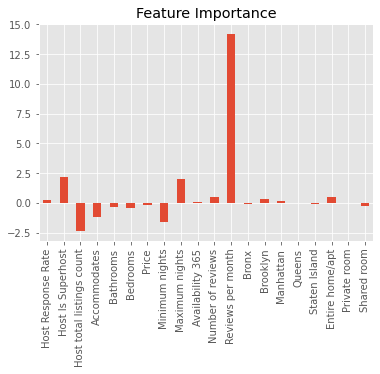

In [92]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(clf.coef_[0],index=data.columns[0:20])
weights.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

#### Interpretation:
I understand that these values shown above may cause some worry about variable scaling. However, the entire dataset used in the models was scaled before model creation. The most significant variables will be discussed below.

##### Reviews per Month:
The highest feature with the highest magnitude of importance - this indicates that when a rental has more reviews per month, it is much more likely to get an overall rating or 90 or above (and A). This makes sense! More reviews means more bookings, and more bookings are much more likely if the past reviews are high instead of low.

##### Host is Superhost:
This has a fairly significant positive value. Again, this makes sense, as superhosts are likely to be more invested in their rentals, leading to higher review scores.

##### Maximum Nights:
Some postulating here - a higher maximum nights value should give renters more flexibility. Additionally, if clients are spending longer amounts of time in a rental, the property owner may feel more motivated to keep it maintained.

##### Host Total Listings Count:
This is the most negative variable. A possible explanation is that property owners that manage large numbers of rentals likely have less time to take care of each individual one.

##### City

Brooklyn: 0.2959
Manhattan: 0.129
Queens: 0.00
Bronx: -0.0573
Staten Island: -0.1285

These values check out from my very novice understanding of New York City. You could theorize that Brooklyn likely has larger rentals that skew a little cheaper than Manhattan. For Queens, Bronx, and Staten Island, these values almost correlate with distance to Manhattan.

##### Room Type

Entire Home / Apt: .5222
Private Room: 0.0
Shared Room: -0.2307

These variables come accross exactly how we would expect. It makes complete sense that renters with a shared room would rate the Airbnbs lower than if they had a private room or entire rental to themselves.

## Interpret Support Vectors

In [109]:
df_tested_on = data.iloc[svm_clf.support_].copy()
print (data.iloc[svm_clf.support_])

#I need my trained model
df_support = df_tested_on.loc[svm_clf.support_,:].copy()
df_support.info()

       Host Response Rate  Host Is Superhost  Host total listings count  \
2                     1.0                0.0                   0.016343   
4                     1.0                0.0                   0.001021   
5                     1.0                0.0                   0.005107   
6                     1.0                1.0                   0.002043   
7                     1.0                0.0                   0.003064   
...                   ...                ...                        ...   
35208                 1.0                0.0                   0.001021   
35212                 1.0                0.0                   0.001021   
35213                 1.0                0.0                   0.001021   
35215                 1.0                0.0                   0.001021   
35217                 1.0                0.0                   0.001021   

       Accommodates  Bathrooms  Bedrooms     Price  Minimum nights  \
2          0.200000   0.19354

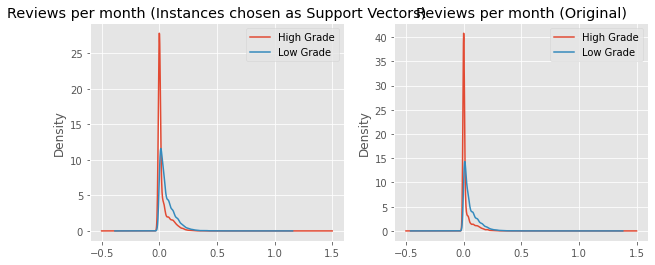

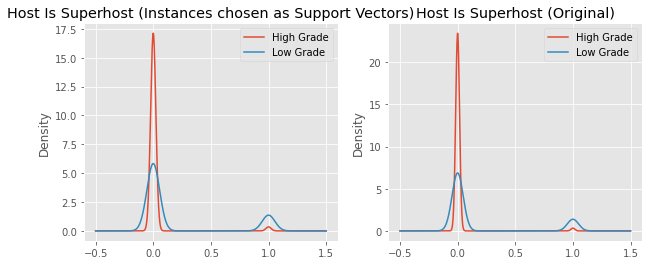

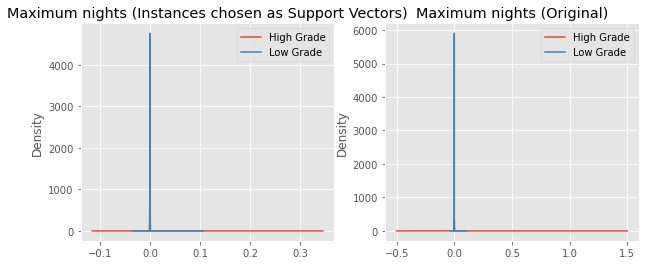

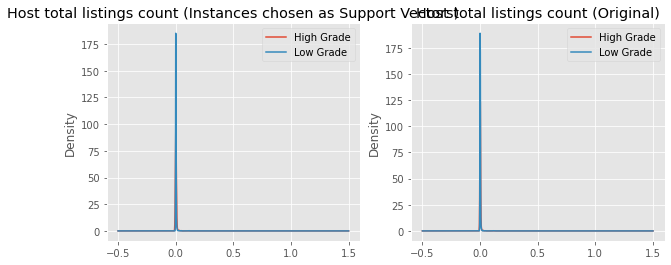

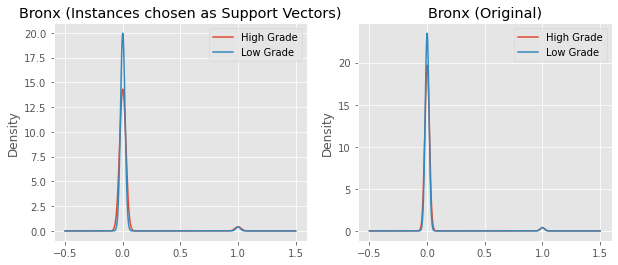

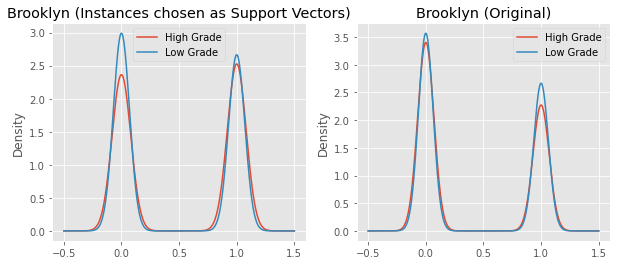

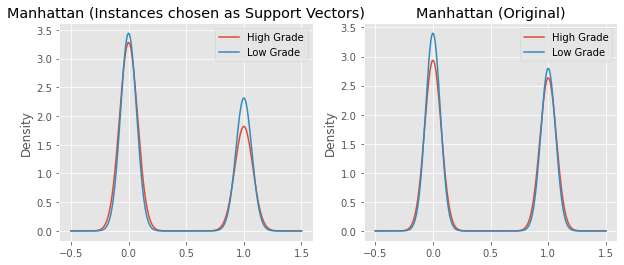

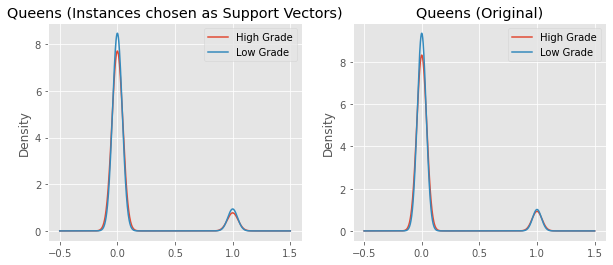

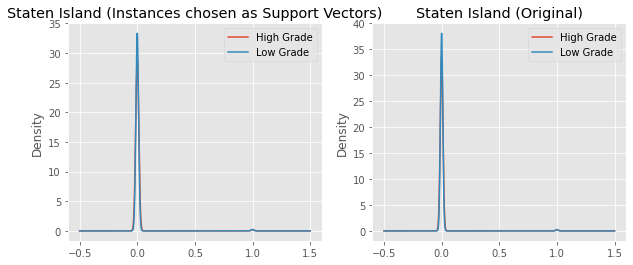

In [110]:
%matplotlib inline
from matplotlib import pyplot as plt
from pandas.plotting import boxplot

df_grouped_support = df_support.groupby(['Grade'])
df_grouped = data.groupby(['Grade'])
vars_to_plot = ['Reviews per month','Host Is Superhost', 'Maximum nights','Host total listings count','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['High Grade','Low Grade'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['High Grade','Low Grade'])
    plt.title(v+' (Original)')

#### Interpretation

As discussed above the features we ended up selecting for comparison were 'Reviews per month','Host Is Superhost', 'Maximum nights','Host total listings count','Bronx','Brooklyn','Manhattan','Queens','Staten Island'

We wanted to keep the features that were tested uniform throughout the lab. We did not use the 'Room type' feature here due to how the data is inputted (entire apt, private room, shared room), it just felt more natural to have these features being compared by their distinction of a high/low grade. From above, any grade below a 90 is deemed 'low', and anything above is deemed 'high'.

Amongst all of these features. I think that the most interesting feature to explore lately has been the "Host Is Superhost" feature. The superhost distinction really is telling to see if a grade will or will not be designated as high. The density tends to be a bit higher in scale on the support vector graph too. This is most likely going to be a linear sepreable variable.

Reviews per month also has a lot more density on the support vector, and there also tends to be a little less seperation. Why I think this might be is that people who are staying at more reviewed places are probably renting from superhosts, which we have seen in the past is positively correlated with higher grades.